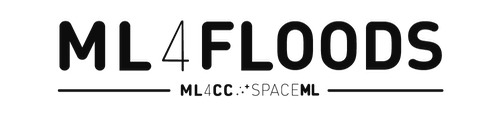

# Tutorial 4: Use probabilistic Flood extent segmentation models to measure Flood event uncertainty

## Step 0: Notebook setup
    - Configure notebook basics
    - Configure GCP Credentials

In [2]:
import sys, os
from pathlib import Path
from pyprojroot import here
# spyder up to find the root
root = here(project_files=[".here"])
# append to path
sys.path.append(str(here()))

os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "/opt/creds/ML4CC_creds.json"

%load_ext autoreload
%autoreload 2

## Step 1: Setup Configuration file
    - Load configuration file from local device or gcs

In [3]:
from src.models.config_setup import get_default_config

config_fp = os.path.join(root, 'src', 'models', 'configurations', 'worldfloods_uncertainty.json')
config = get_default_config(config_fp)

Loaded Config for experiment:  worldfloods_uncertainty_demo
{   'data_params': {   'batch_size': 32,
                       'bucket_id': 'ml4floods',
                       'channel_configuration': 'all',
                       'input_folder': 'S2',
                       'loader_type': 'local',
                       'num_workers': 8,
                       'path_to_splits': '/worldfloods/public',
                       'target_folder': 'gt',
                       'test_transformation': {   'normalize': True,
                                                  'num_classes': 3,
                                                  'totensor': True},
                       'train_test_split_file': 'worldfloods/public/train_test_split.json',
                       'train_transformation': {   'normalize': True,
                                                   'num_classes': 3,
                                                   'totensor': True},
                       'window_size': [256, 2

## Step 2: Setup Dataloader
    - 'loader_type' can be one of 'local' which assumes the images are already saved locally, or 'bucket' which will load images directly from the bucket specified in 'bucket_id'

In [4]:
from src.models import dataset_setup

# Configure the dataset to load from local storage
data_module = dataset_setup.get_dataset(config.data_params)

# Get just the test dataloader
dl = data_module.test_dataloader()

Using local dataset for this run
train 196648  tiles
val 1284  tiles
test 11  tiles


## Step 3: Load a pre-trained model or checkpoint
    - Currently models that support probabilistic segmentation include:
        1. 'unet_dropout' which achieves probabilistic segmentation via dropout during inference

In [5]:
from pytorch_lightning.utilities.cloud_io import load
from src.models.model_setup import get_model
import torch

print('Model type: ', config.model_params.hyperparameters.model_type)

path_to_models = f"{config.model_params.model_folder}/{config.experiment_name}/model.pt"

# Load probabilistic version of model for sampling varying predictions
prob_model = get_model(config.model_params)
prob_model.load_state_dict(load(path_to_models))
prob_model.to(torch.device("cuda:0"))

# Load deterministic version of model for sampling consistent predictions
det_model = get_model(config.model_params)
det_model.load_state_dict(load(path_to_models))
det_model.to(torch.device("cuda:0"))

Model type:  unet_dropout
13 3
13 3


WorldFloodsModel(
  (network): UNet_dropout(
    (dconv_down1): Sequential(
      (0): Conv2d(13, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
    )
    (dconv_down2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
    )
    (dconv_down3): Sequential(
      (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
    )
    (dconv_down4): Sequential(
      (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(512, 512, kernel_size=(3, 3), stride=

## Step 4: Get Inference Function for model
    -- This handles tiling and padded prediction over large images and enables us to query multiple samples from the network to obtain uncertainty estimates 
    -- eval_mode=False enables dropout during inference to give us probabilistic samples from the network

In [6]:
from src.models.model_setup import get_model_inference_function

# Get probabilistic and deterministic inference functions
prob_inference_function = get_model_inference_function(prob_model, config, apply_normalization=False, eval_mode=False)
det_inference_function = get_model_inference_function(det_model, config, apply_normalization=False, eval_mode=True)

GEtting model inference function
Max tile size: 256
GEtting model inference function
Max tile size: 256


## Step 5: Run probabilistic inference over dataset to show visual uncertainty of segmentations
    - compute_unecrtainties function samples num_samples predictions from the model and builds several uncertainty maps for visualisation

  0%|          | 0/11 [00:00<?, ?it/s]

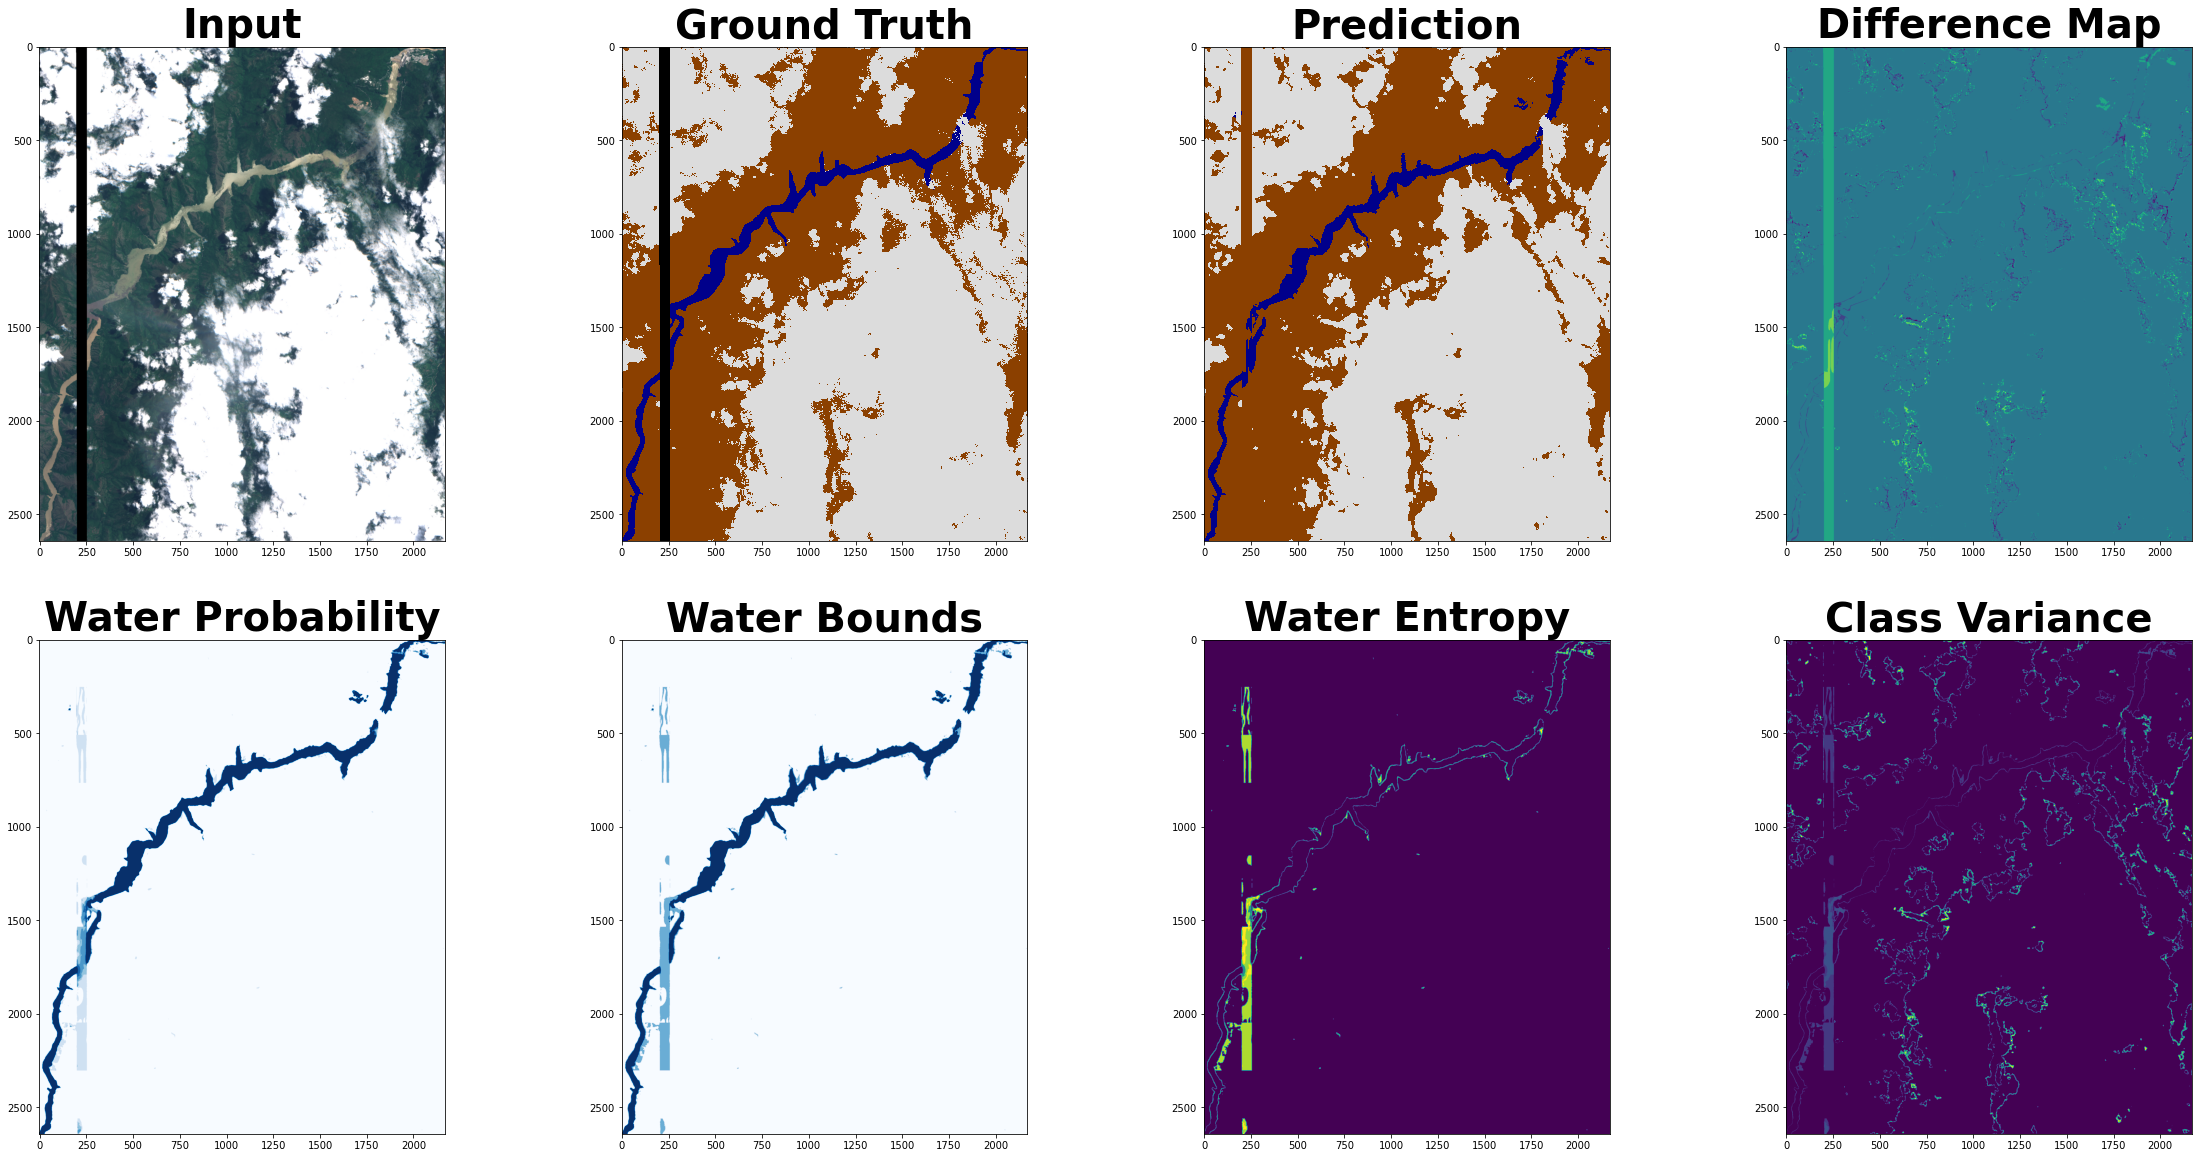

  9%|▉         | 1/11 [00:25<04:17, 25.73s/it]

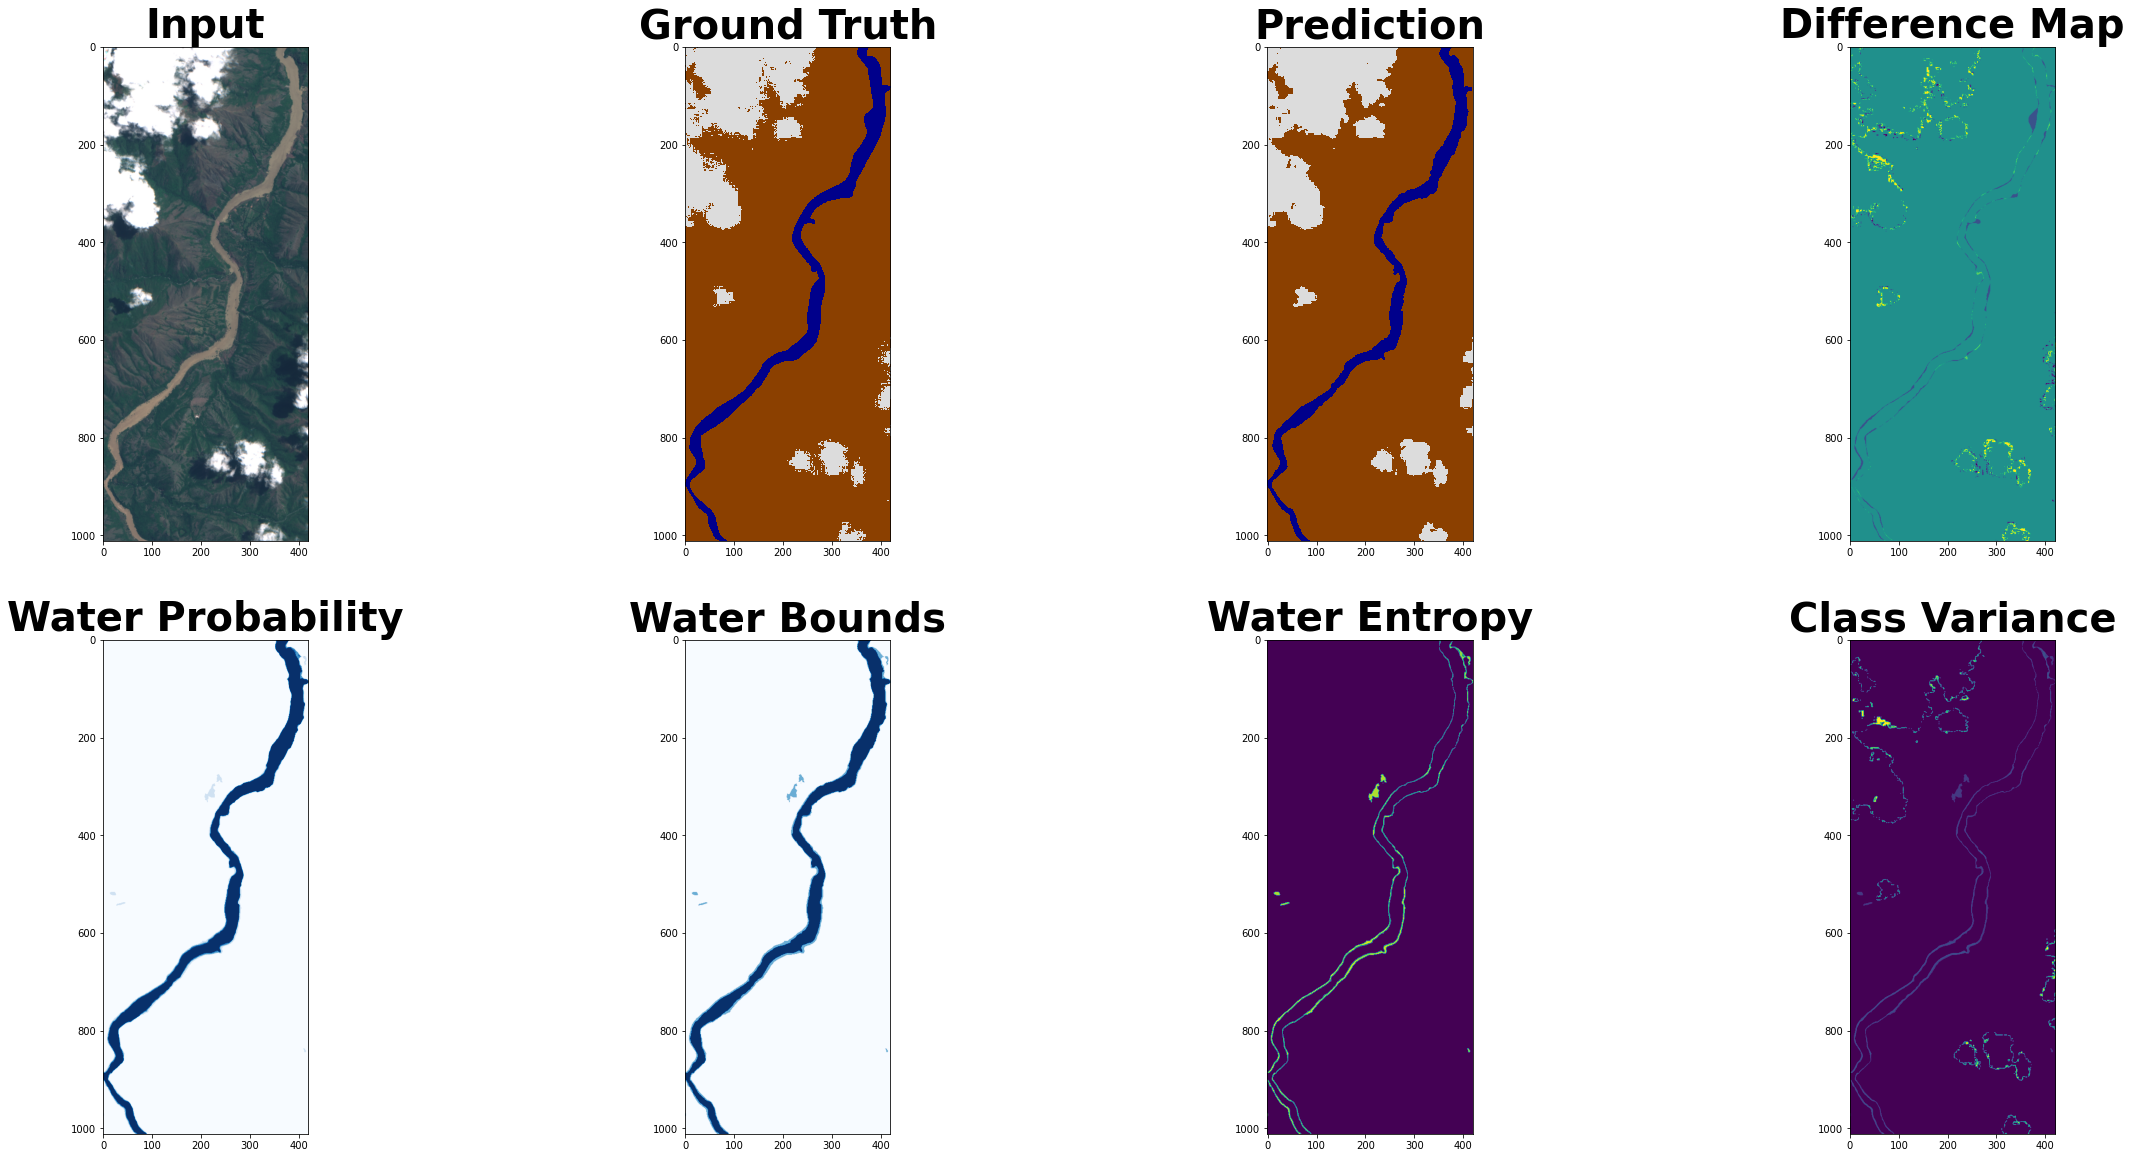

 18%|█▊        | 2/11 [00:28<01:51, 12.37s/it]

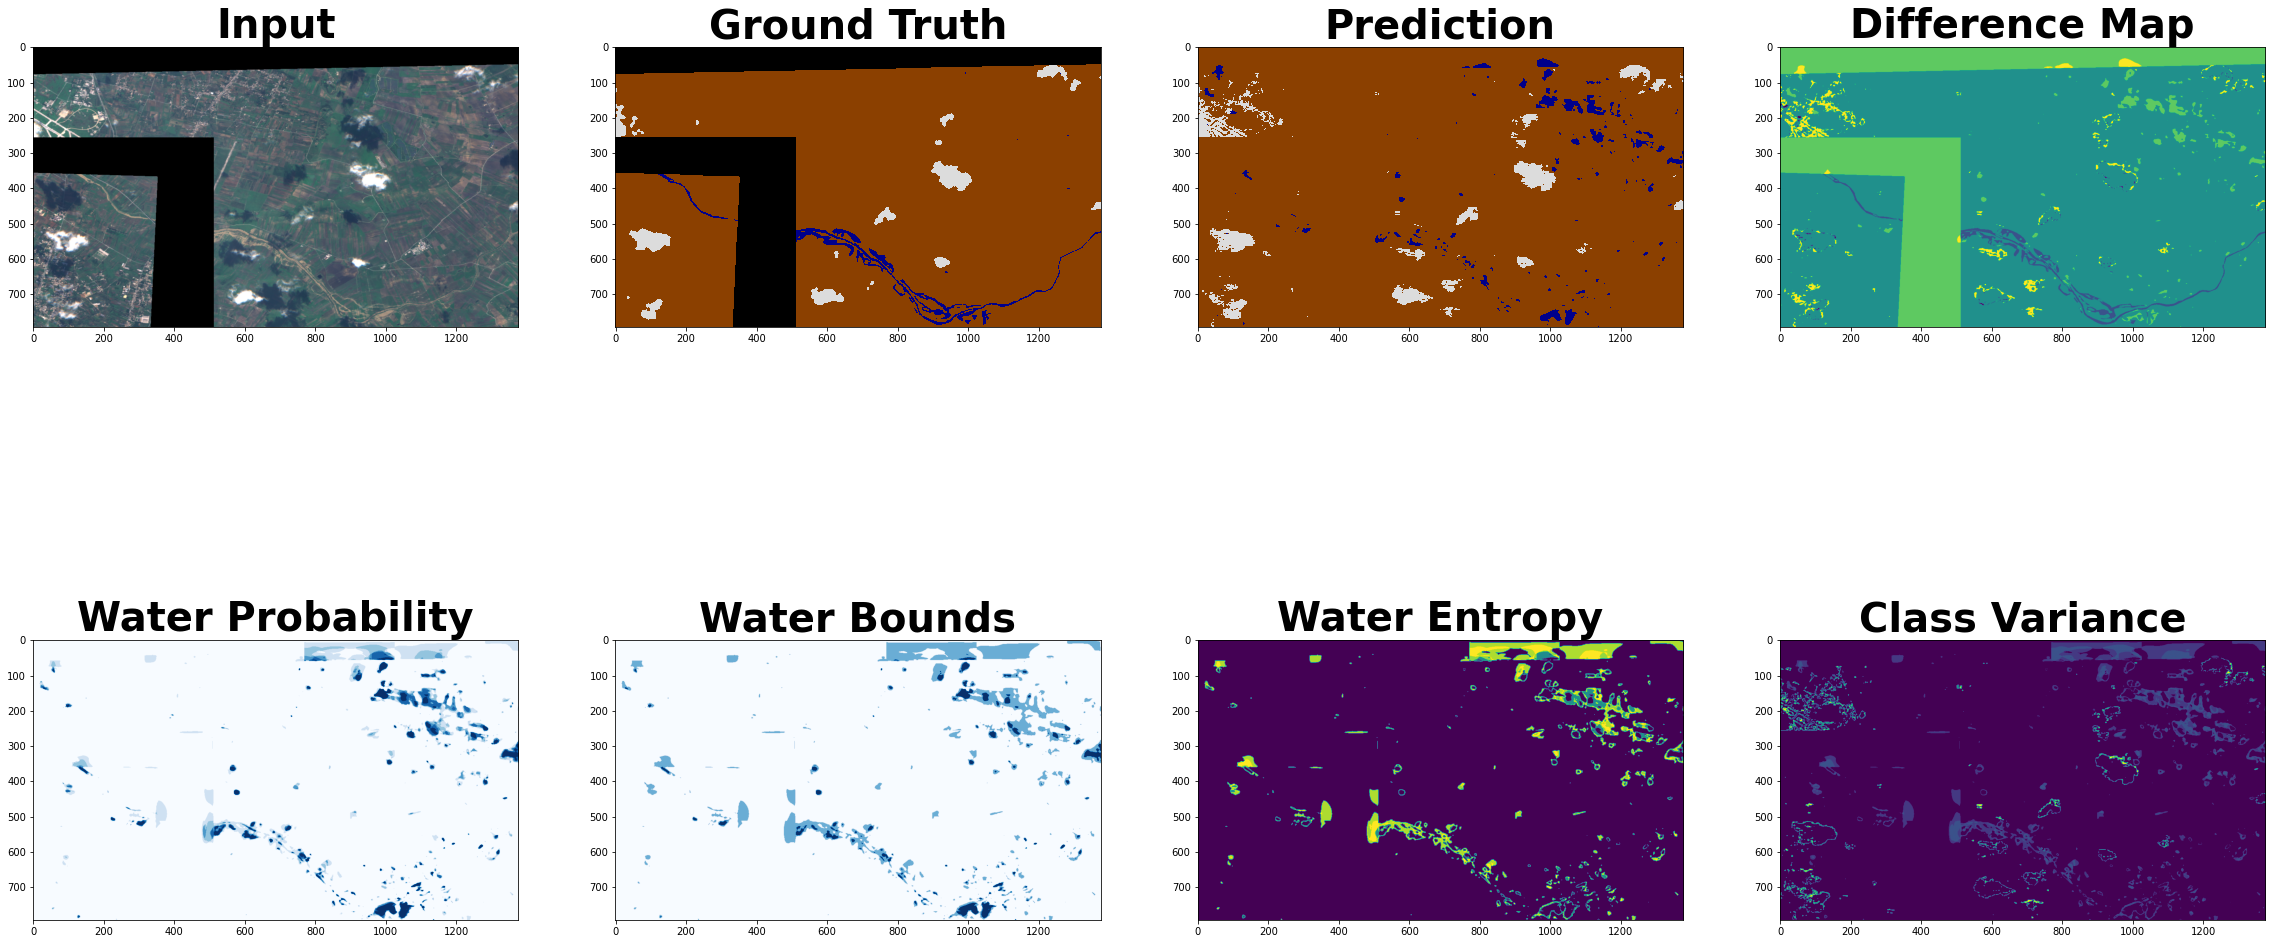

 27%|██▋       | 3/11 [00:34<01:14,  9.25s/it]

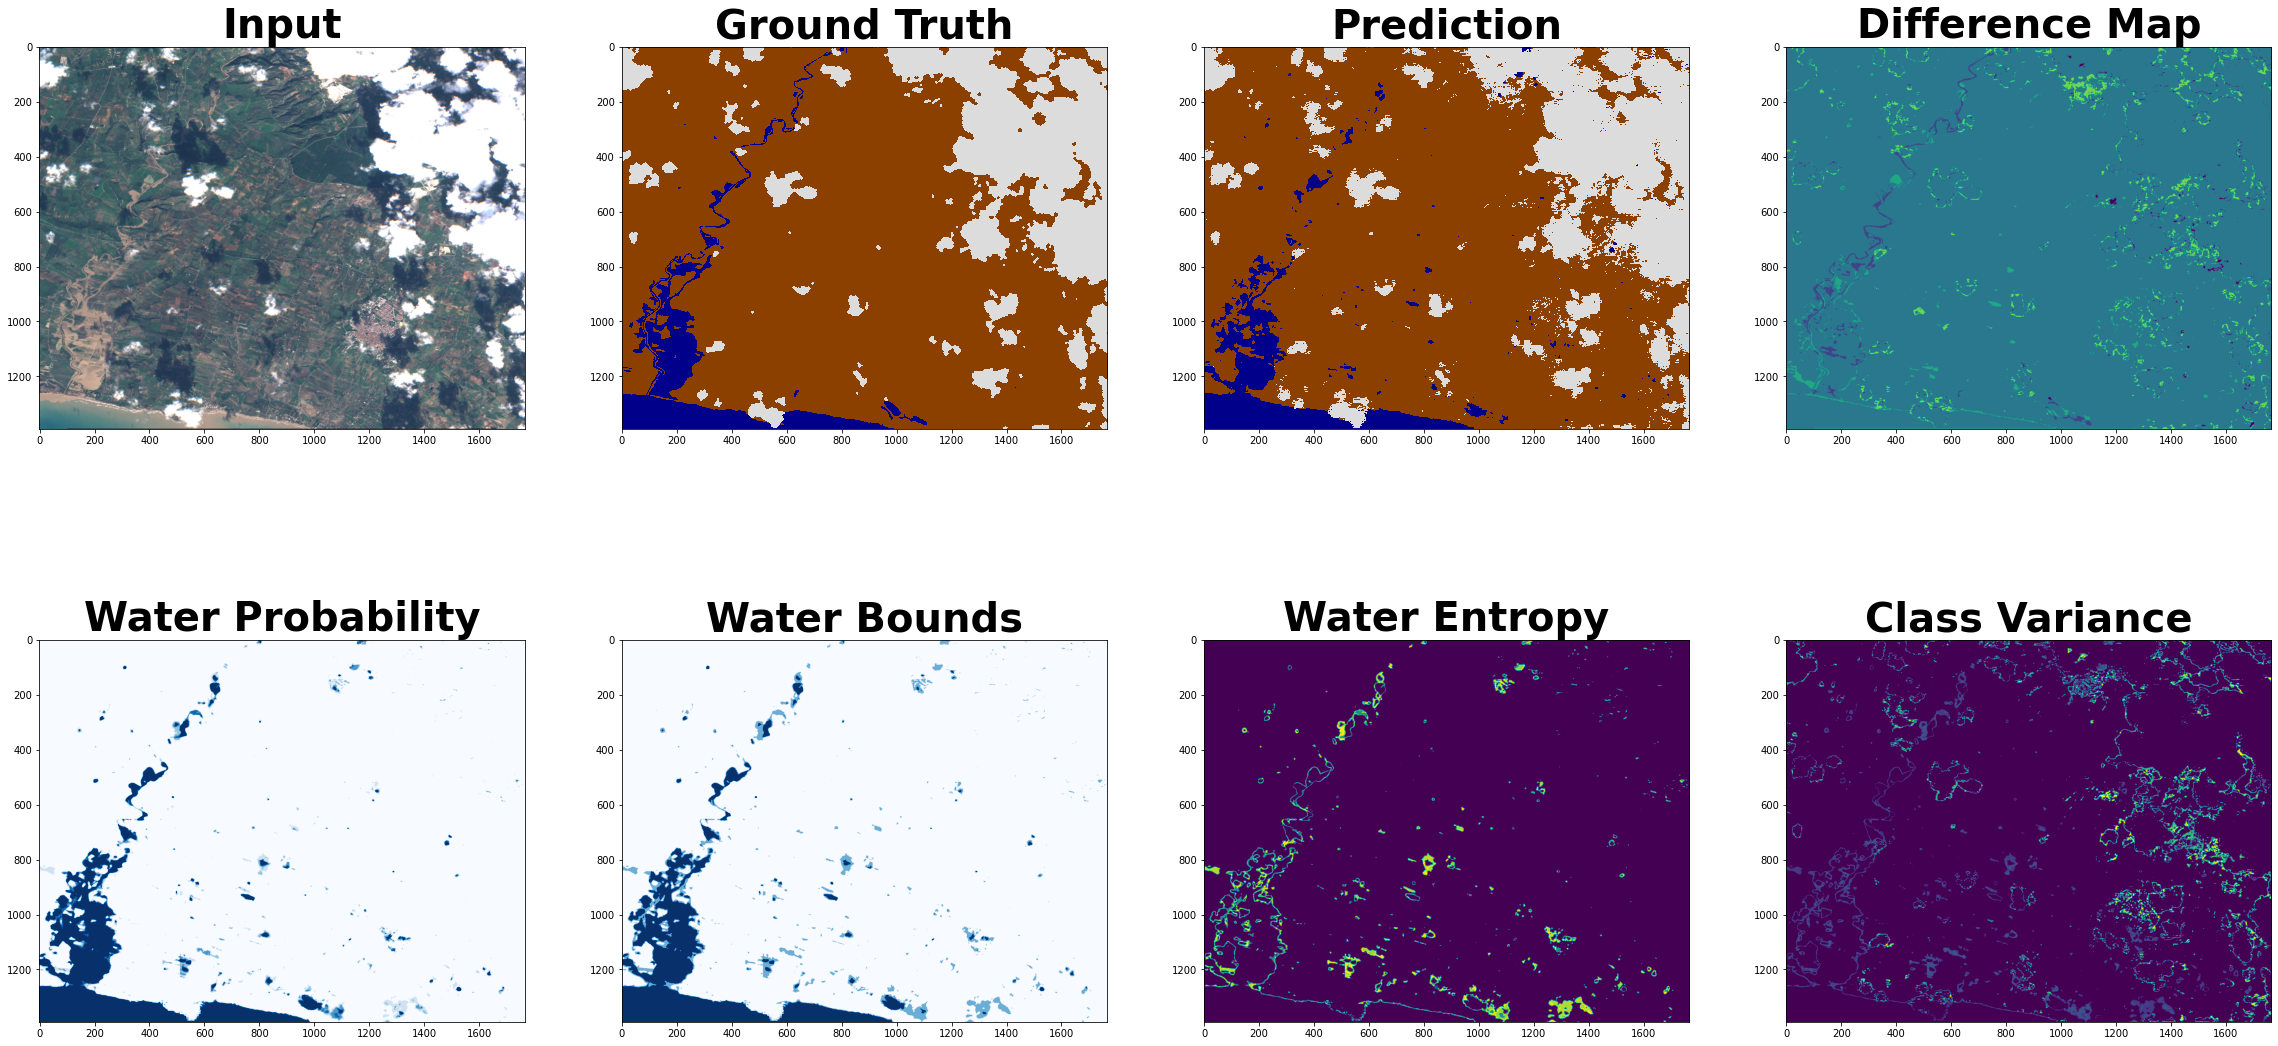

 36%|███▋      | 4/11 [00:45<01:09,  9.90s/it]

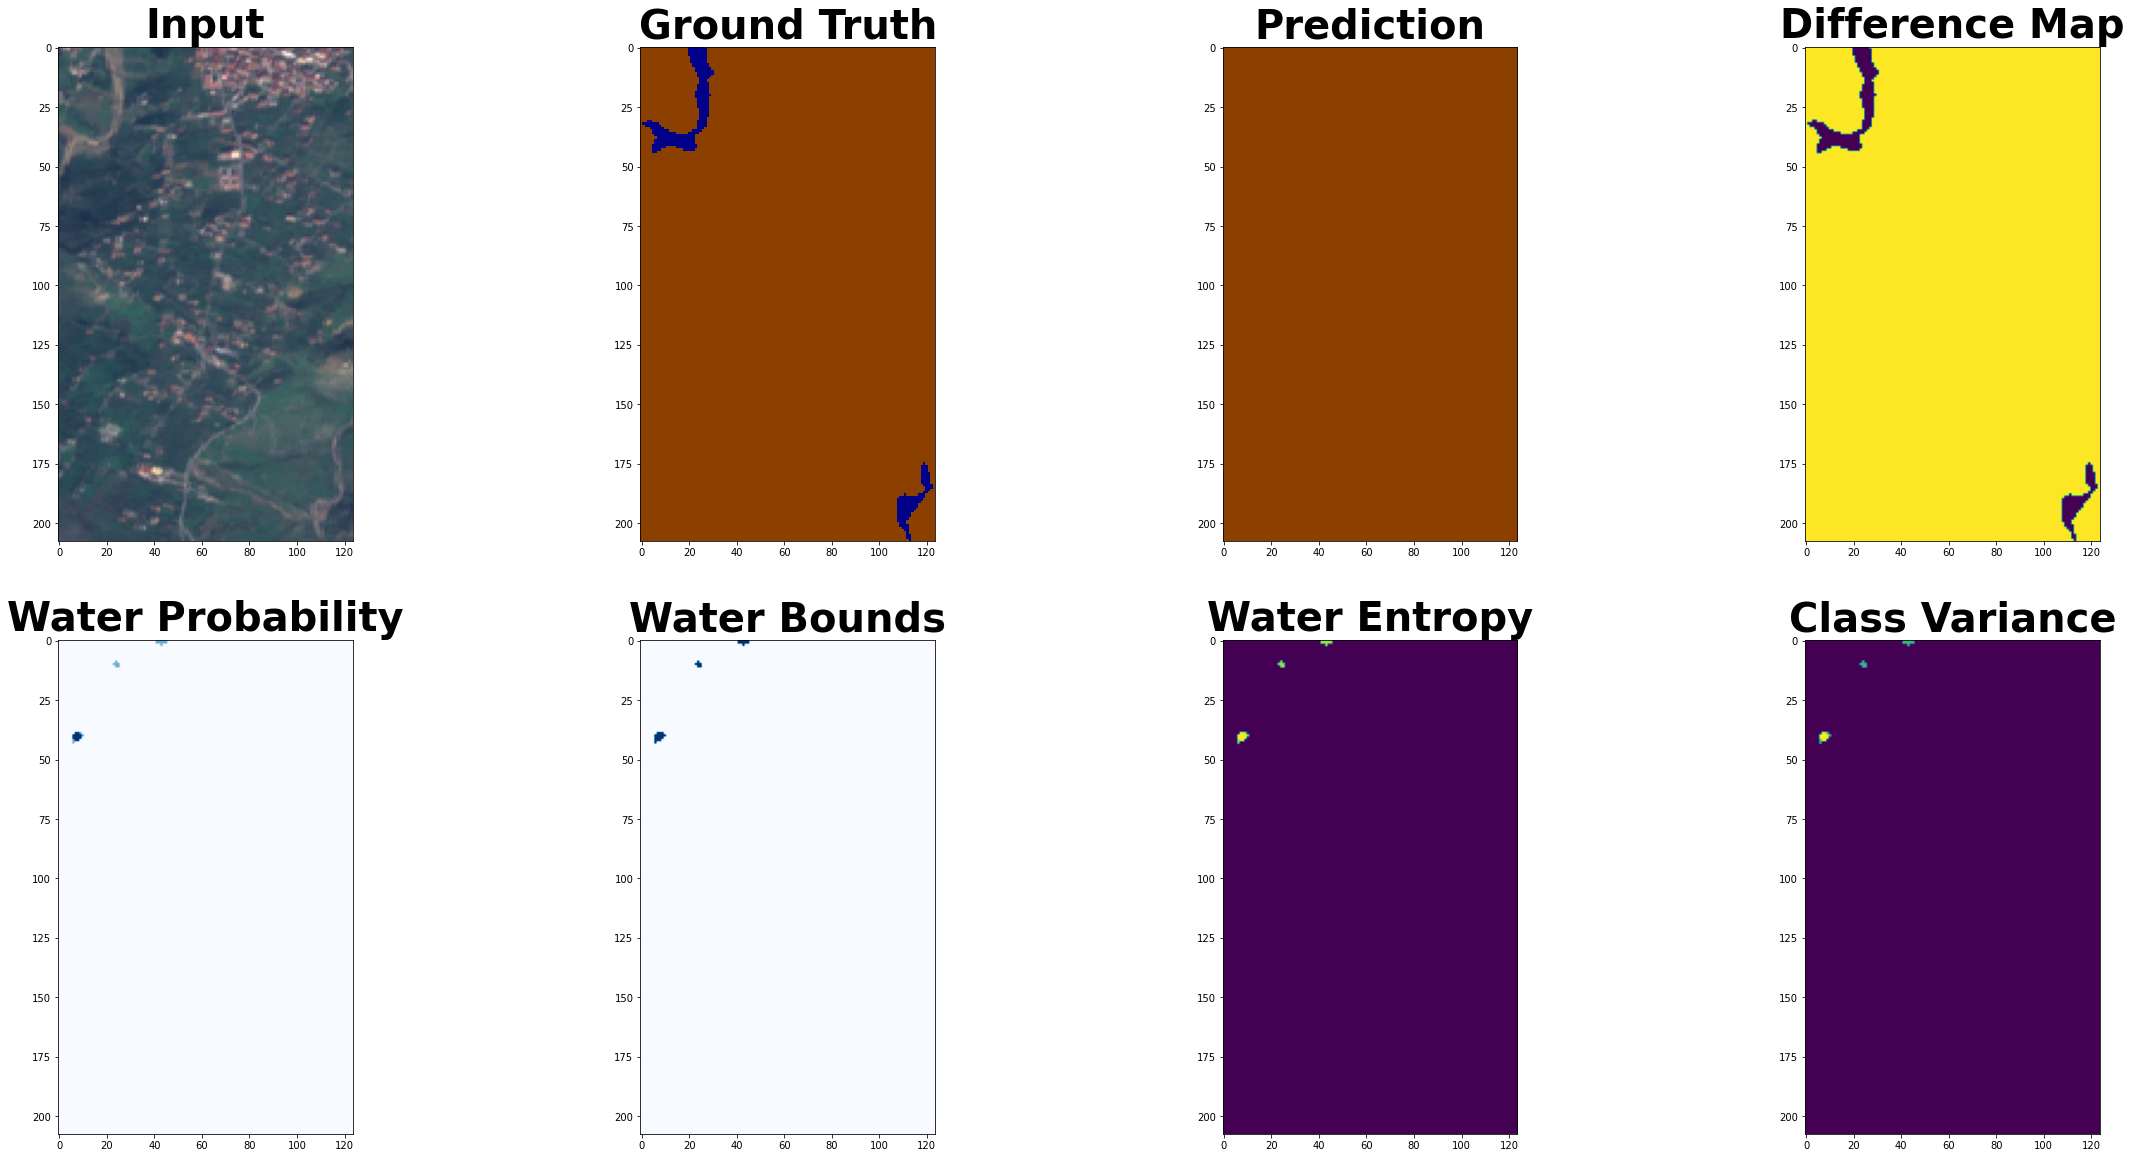

 45%|████▌     | 5/11 [00:46<00:40,  6.82s/it]

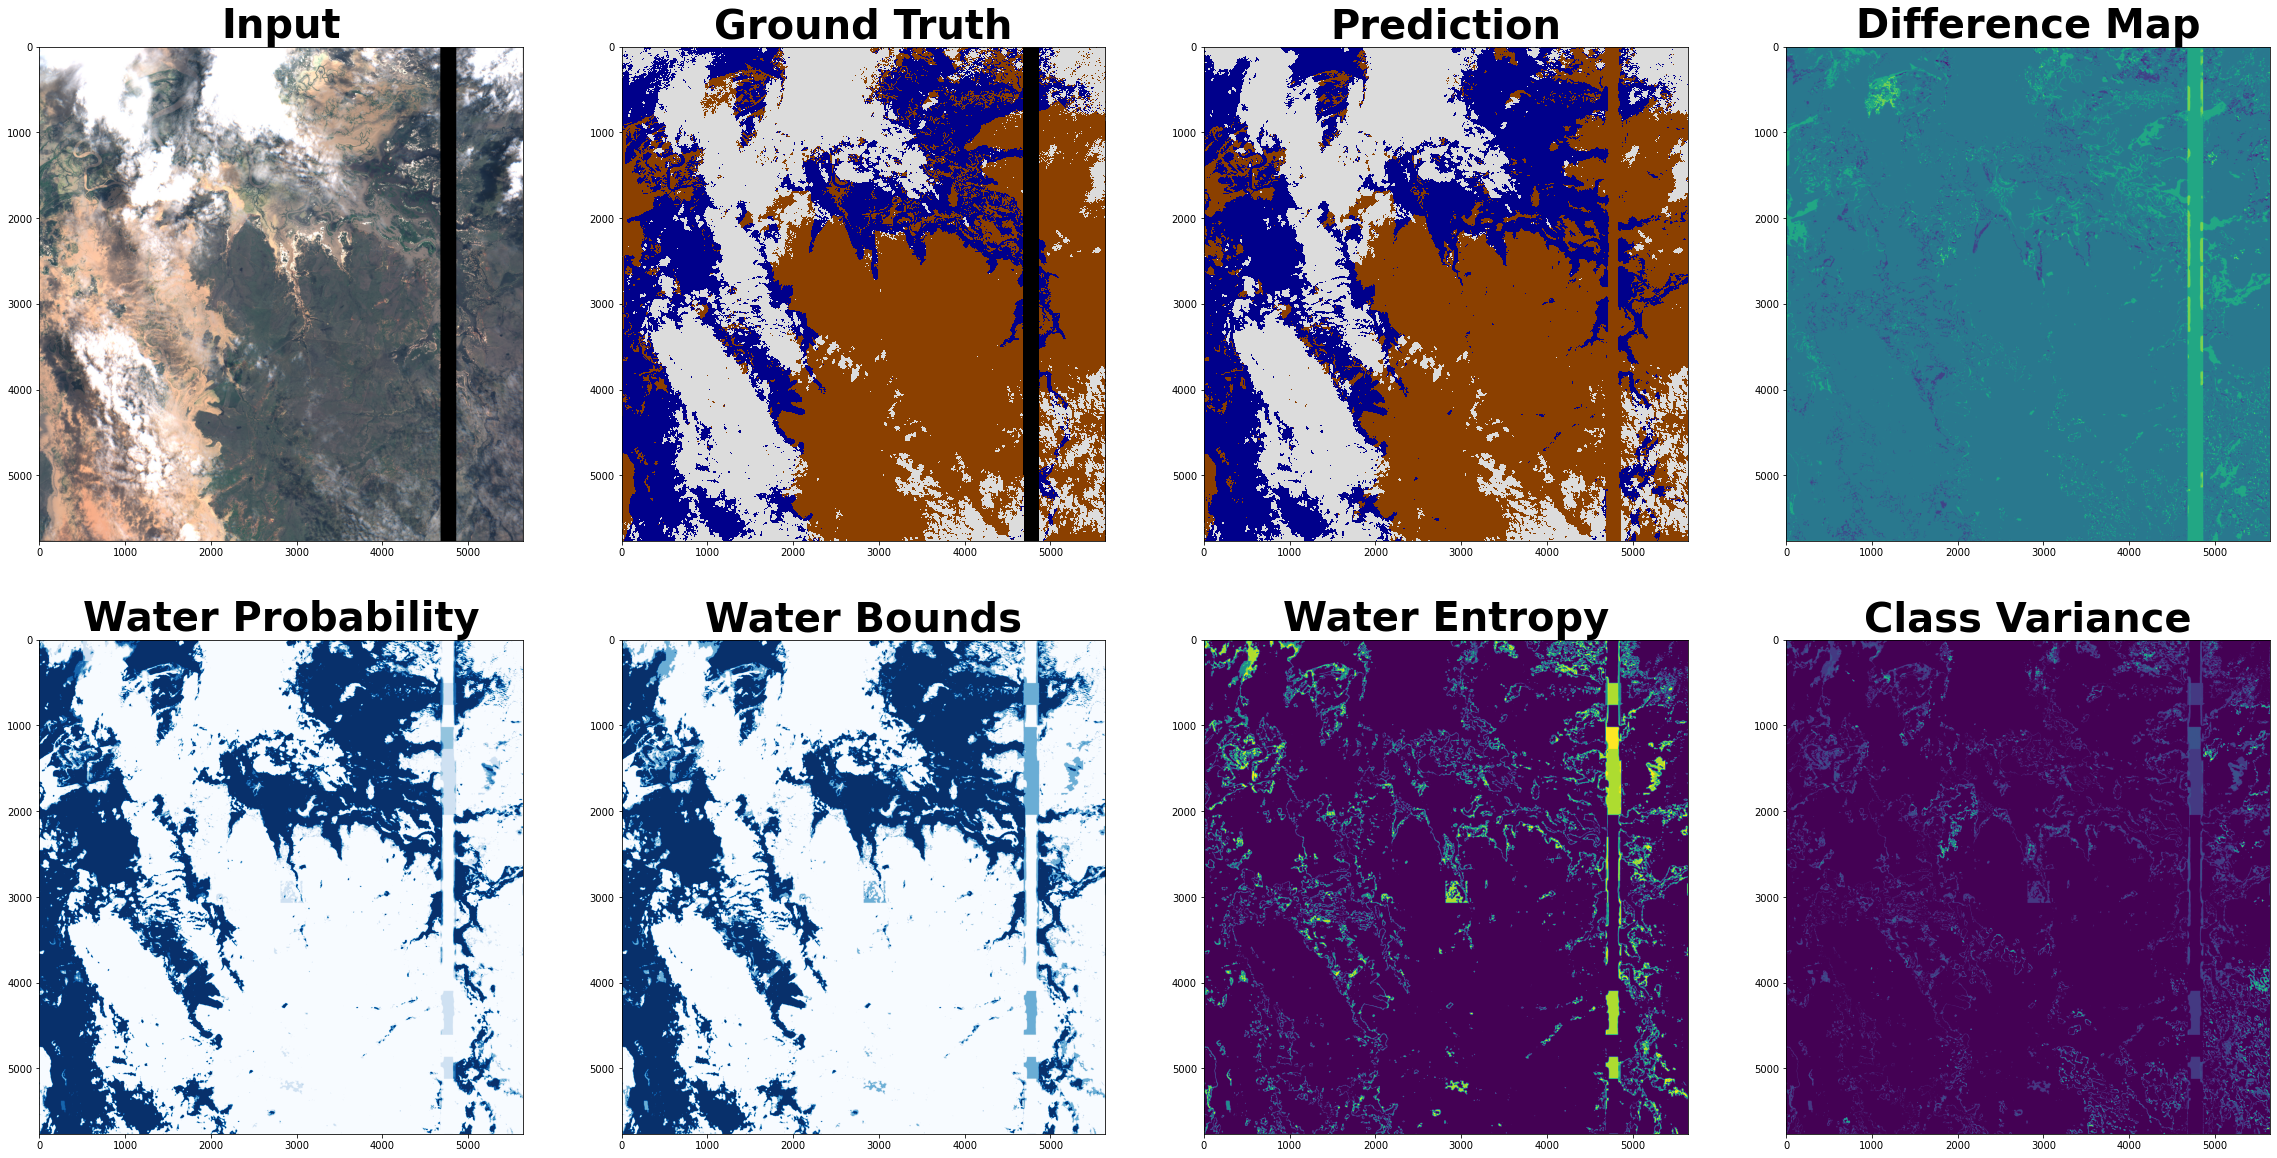

 55%|█████▍    | 6/11 [03:27<04:56, 59.30s/it]

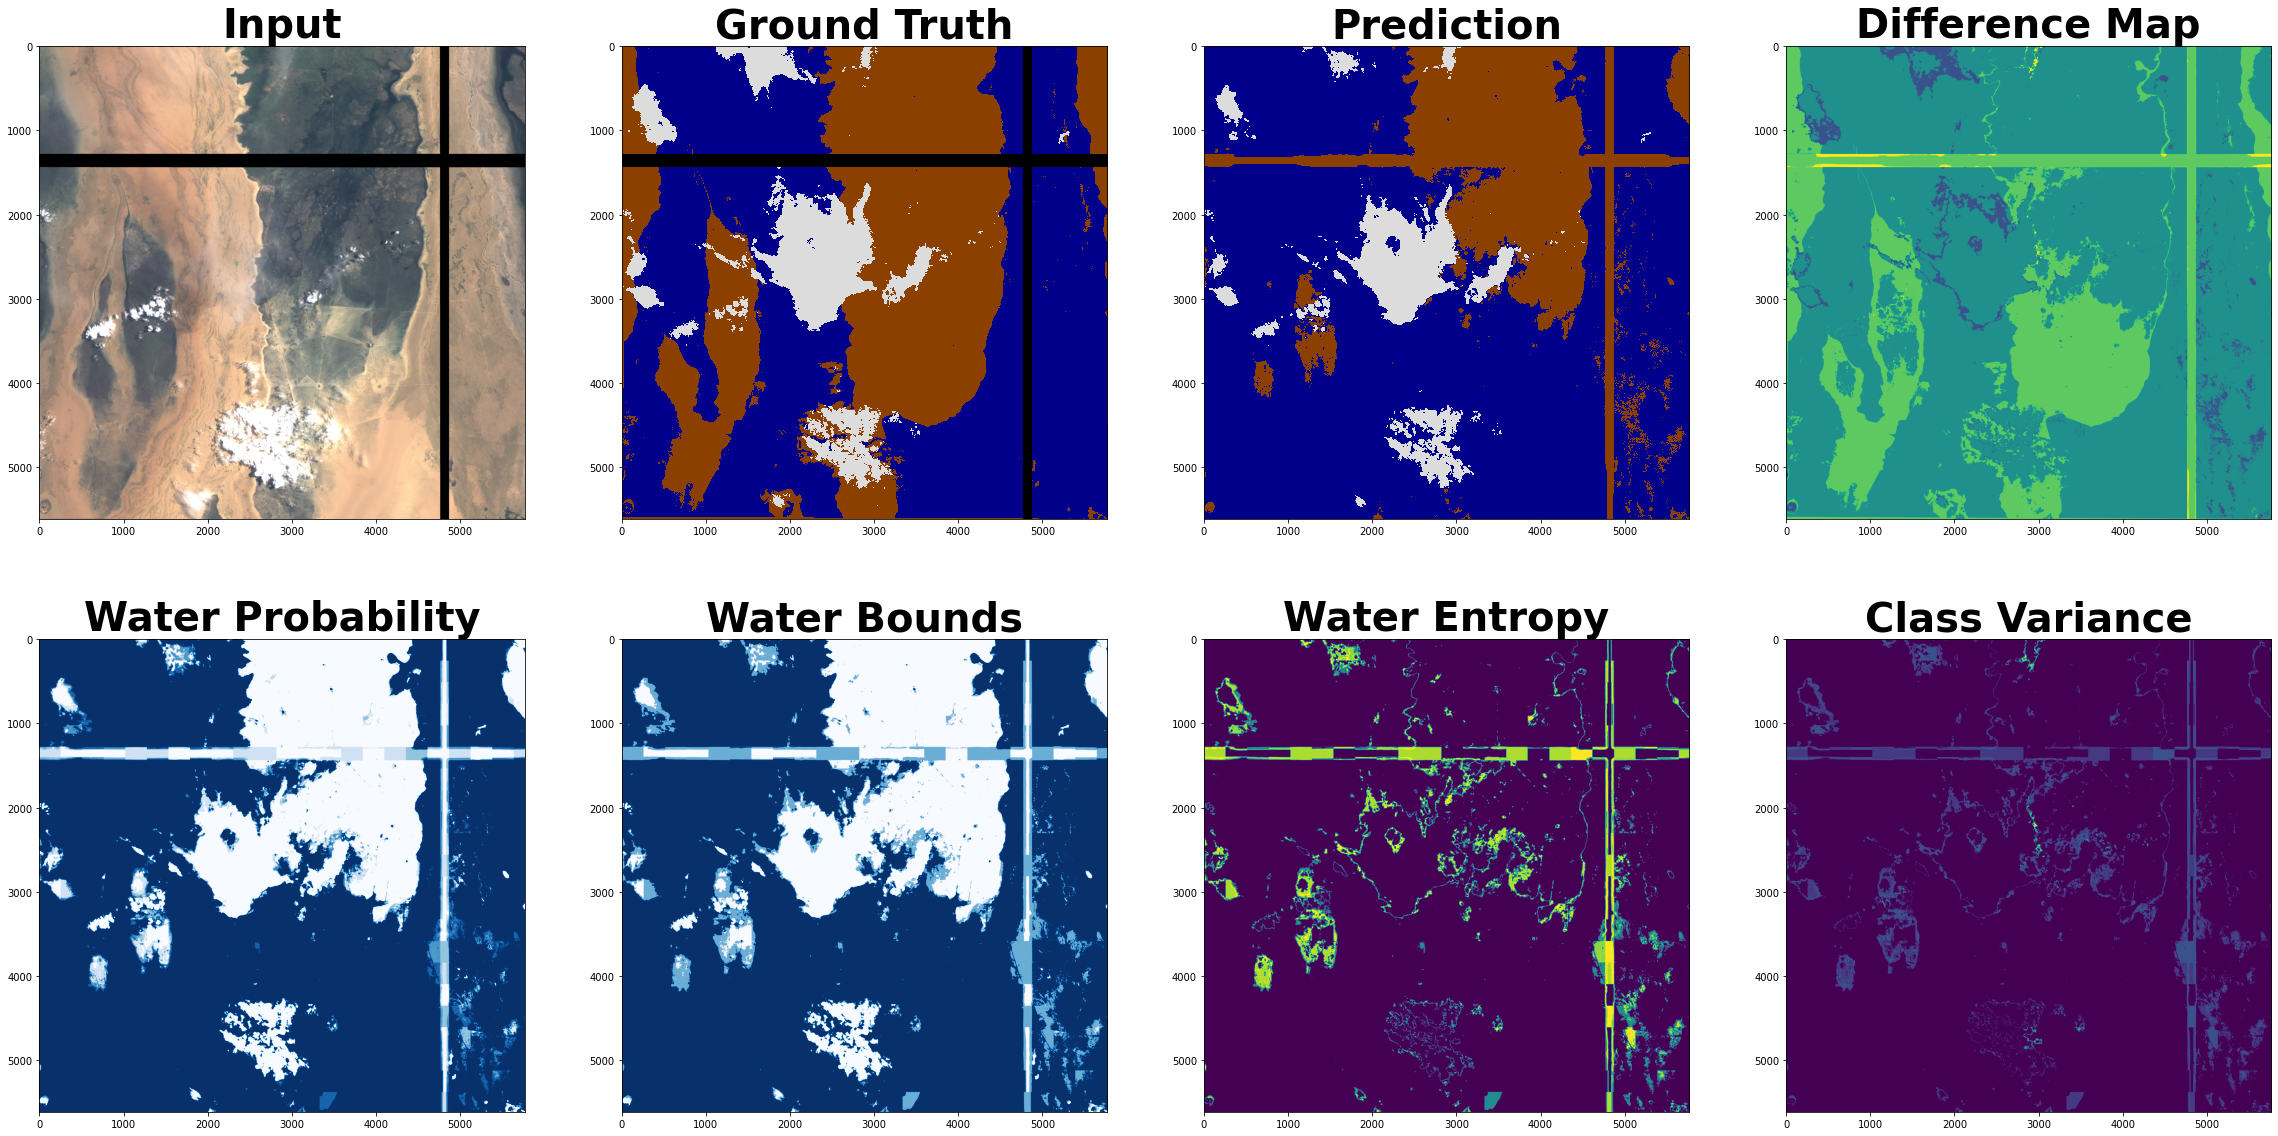

 64%|██████▎   | 7/11 [06:41<06:52, 103.11s/it]

In [ ]:
from src.models.utils import uncertainty

uncertainty.compute_uncertainties(
    dataloader=dl, 
    p_pred_fun=prob_inference_function,
    d_pred_fun=det_inference_function,
    num_class=config.model_params.hyperparameters.num_classes, 
    label_names=config.model_params.hyperparameters.label_names,
    config=config,
    num_samples=5,
    plot=True
)

In [ ]:
print('hello')